In [1]:
import pandas as pd

In [2]:
# instead of importing all the bigrams, it might be simplest just to only generate the econ bigrams
articles = pd.read_csv('../process_articles/processed_articles.csv')
len(articles)

2014

In [3]:
from operator import itemgetter
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')


def get_term_ngrams(text, n, term):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ''.join(grams) for grams in n_grams if term in grams]


def ngram_term_counts(ngram):
    # create word count dictionary
    word_count = {}

    for word in ngram:
        if word in word_count.keys():
            cur_val = word_count[word]
            cur_val += 1
            word_count[word] = cur_val
        else:
            word_count[word] = 1

    # sort the dictionary
    word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}

    return word_count


def get_top_n_ngrams(df:pd.DataFrame, term:str, top_k:int, ngram:int, stopwords=None) -> list:
    """Returns unique list of the combined k most-occuring ngrams for each quarter
    
    Creates a list of ngrams containing the term for each article, counts occurance of each, 
    and then creates a combined total for all ngrams in the quarter. Finds k most common ngrams
    in each quarter, and then combines the unique ngrams into one list.

    Args:
        df (pd.DataFrame):
            Dataframe of the articles
        term (str):
            Chinese word (doesn't handle phrases) to find the context of. 
        top_k (int):
            Number of ngrams per quarter you want to include. For example, top_k = 1
            only combines the single most frequent ngrams from each quarter. top_k = 2
            combines the two most frequent ngrams from each quarter. 
        ngram (int):
            Length in words of ngrams to be calculated.
        stopwords (list(str)):
            ngrams to exclude, like "经济和" (which is already exluded by default)
        
    Returns:
        List of the unqiue words that occured at least once in the top k ngrams for one of 
        the quarters. 

    Examples:
        ```
        # returns list of bigrams that were the most frequent in at least one quarter
        get_top_n_ngrams(articles, "经济", 1, 2)

        # returns list of trigrams that were in the top 2 for at least one quarter
        get_top_n_ngrams(articles, "经济", 2, 3)
        ```
    """
    # generate and store the ngrams for each article that contain the term
    df[term+'_bigram'] = df['cleaned_text_wspaces'].map(lambda x: get_term_ngrams(x, ngram, term))
    # print(df[term+'_bigram'].head(10))
    # print()

    # calculate and store ngram count dictionary for each article
    df[term+'_bigram_count'] = df[term+'_bigram'].map(lambda x: ngram_term_counts(x))
    # print(df[term+'_bigram_count'].head(10))

    # create an empty dictionary to store the term-counts for each quarter
    quarters = list(df['year_quarter'].unique())
    quarters.sort()

    quarter_ngrams = {}
    for quarter in quarters:
        quarter_ngrams[quarter] = {}
    # print(quarter_ngrams)

    # calculate the complete list of ngrams and their counts for each quarter
    for index, row in articles.iterrows():
        year_quarter = row['year_quarter']

        quarter_ngrams[year_quarter] = {i: row[term+'_bigram_count'].get(i, 0) + quarter_ngrams[year_quarter].get(i, 0) 
            for i in set(row[term+'_bigram_count']).union(quarter_ngrams[year_quarter])}
    print(quarter_ngrams)

    # drop unwanted ngrams
    # declare a list that will store [quarter, key_to_drop] pairs
    to_drop = []
    for quarter in quarter_ngrams:
        # drop any user-defined stopwords - basic ngrams that shouldn't be included
        if stopwords:
            for stopword in stopwords:
                if stopword in quarter_ngrams[quarter].keys():
                    quarter_ngrams[quarter].pop(stopword)
        # drop things that start or end in 对， 在， 像，和， 与，同，了，以，而，为
        auto_drops = ['对', '在', '像','和','与','同','了','以','而','为','的','比','是']
        for key in quarter_ngrams[quarter].keys():
            if (key[0] in auto_drops or key[-1] in auto_drops) and (len(key) <= len(term) + 2*(ngram-2) + 1):
                to_drop.append([quarter, key])

    for quarter, key_to_drop in to_drop:
        quarter_ngrams[quarter].pop(key_to_drop)
    
    print(f"Dropped keys: {set([key for quarter, key in to_drop])}")

    # get the top n most common terms for each quarter
    top_n_pairs = {}
    for quarter in quarter_ngrams:
        top_n_pairs[quarter] = dict(sorted(quarter_ngrams[quarter].items(), key=itemgetter(1), reverse=True)[:top_k])    
    print(f"Top n most common terms: {top_n_pairs}")

    # extract the list of the most common terms for all quarters
    terms = []
    for quarter in top_n_pairs:
        for term in top_n_pairs[quarter]:
            terms.append(term)
    terms = list(set(terms))

    return terms

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calebharding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2014


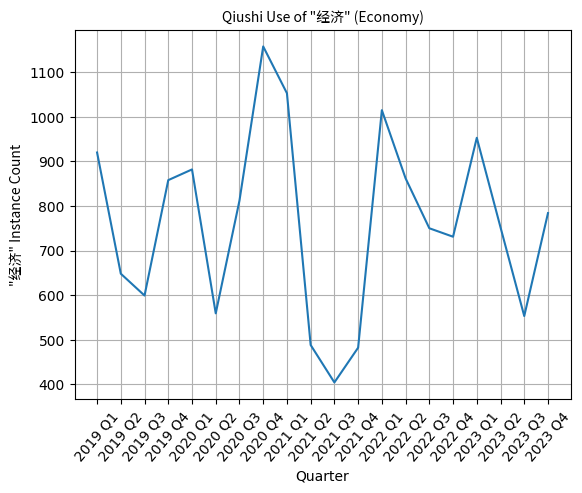

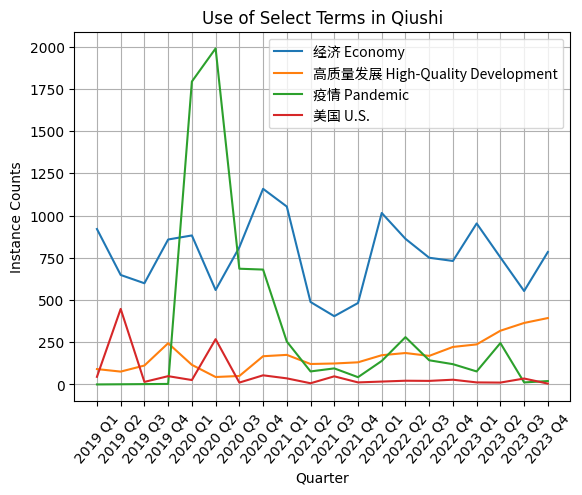

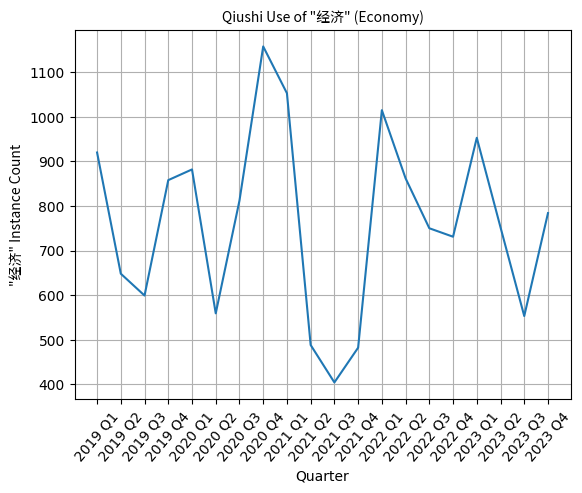

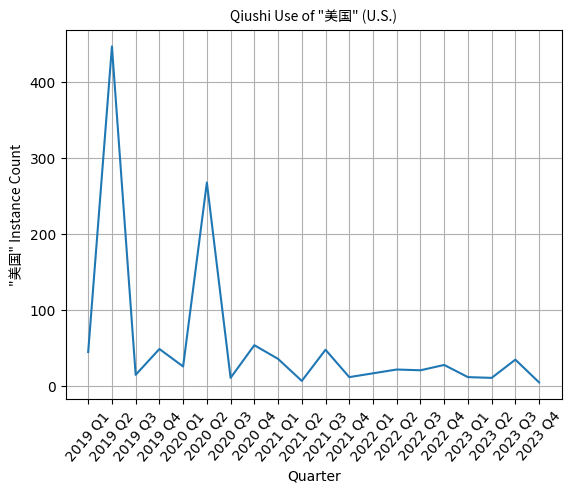

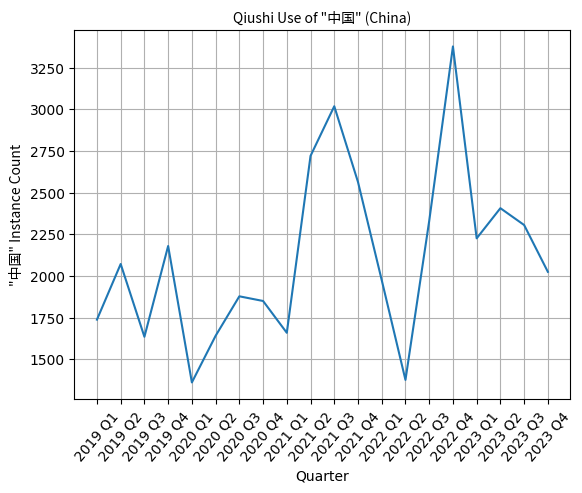

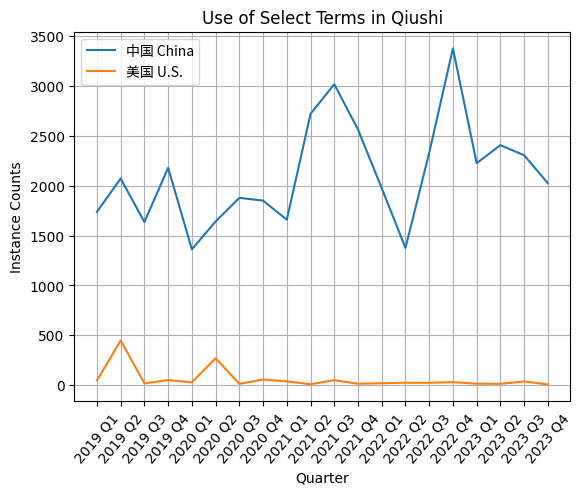

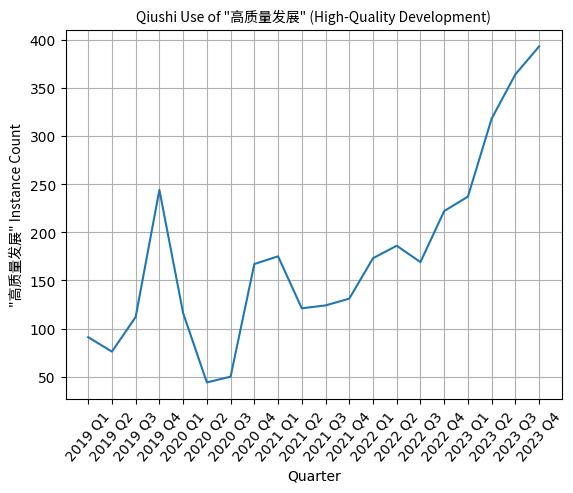

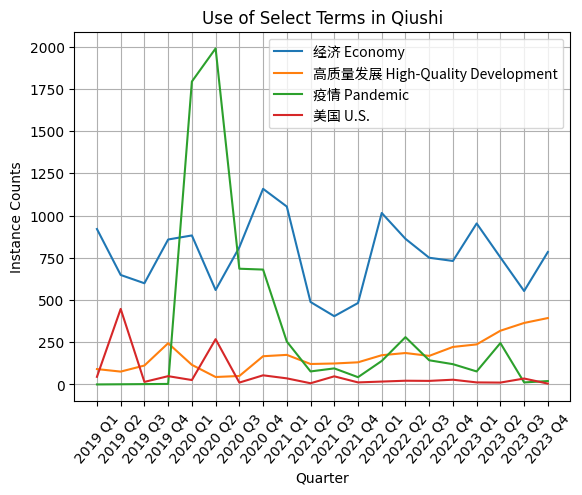

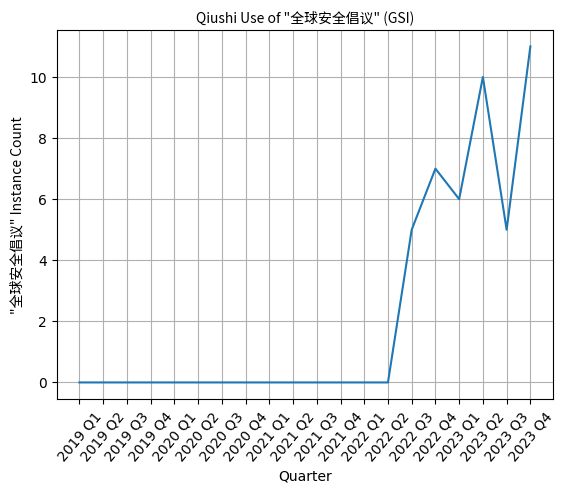

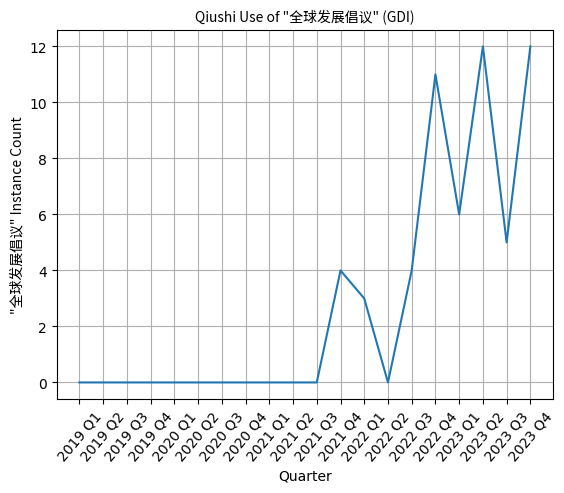

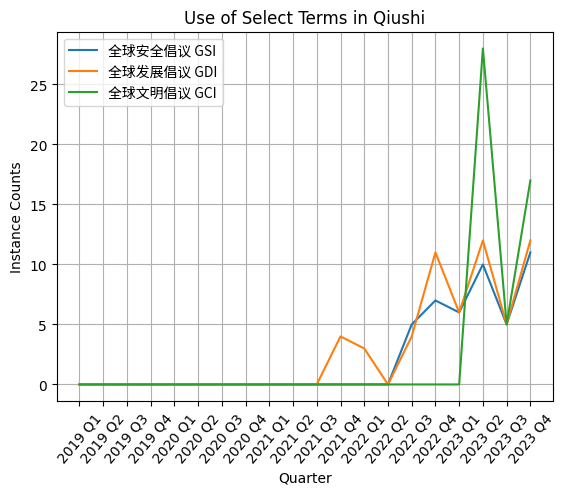

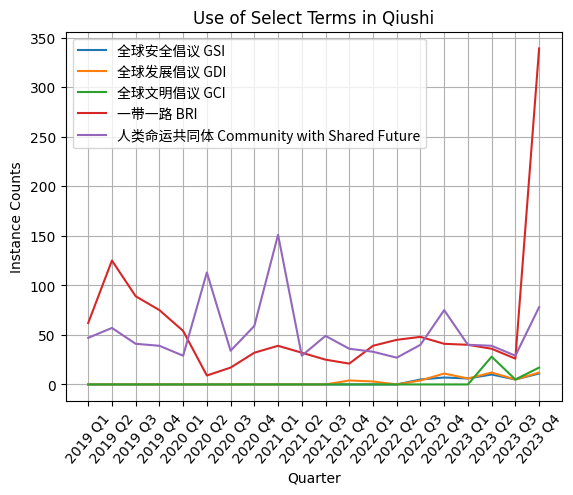

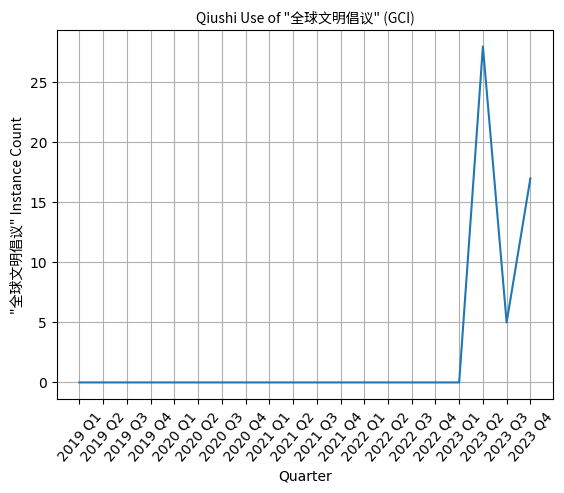

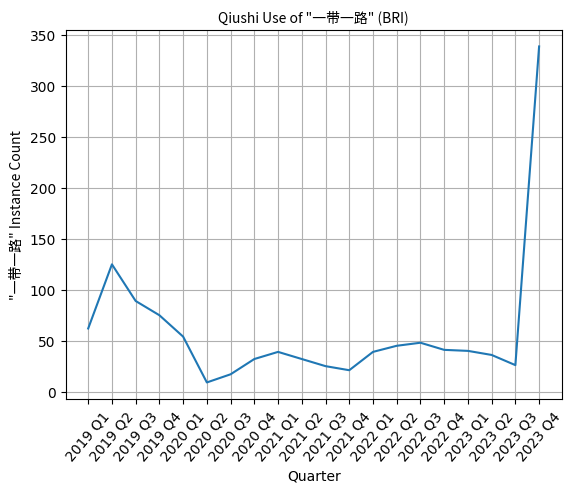

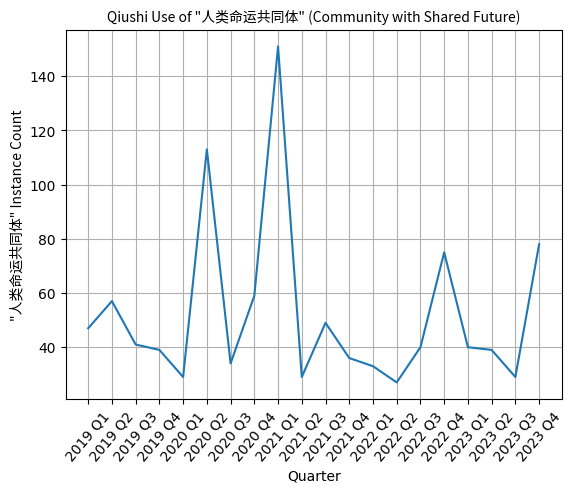

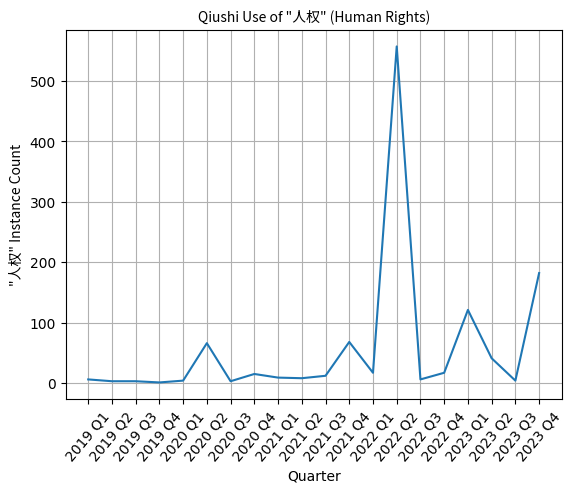

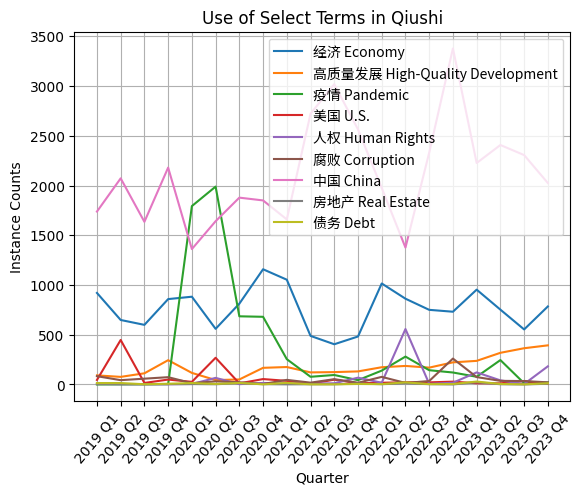

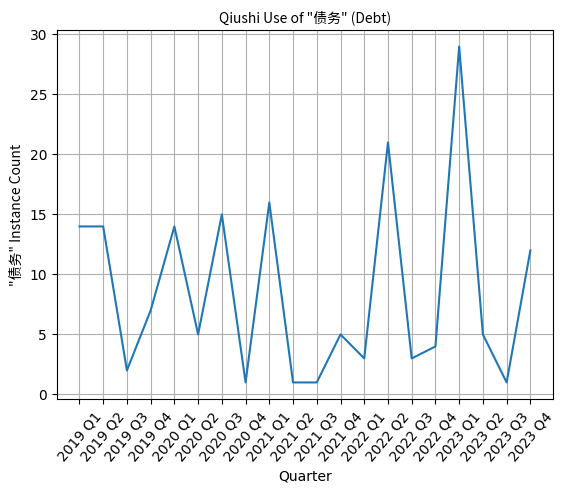

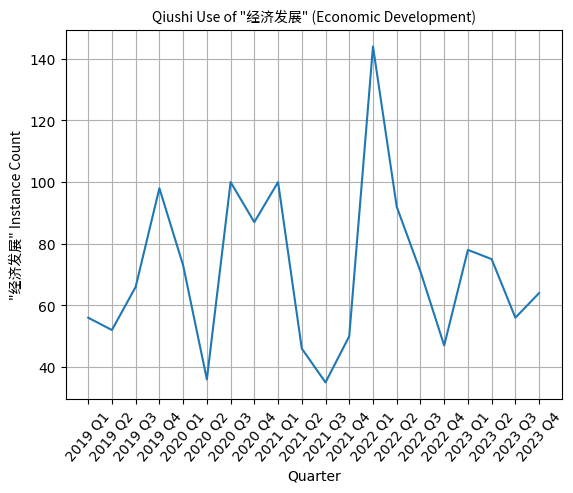

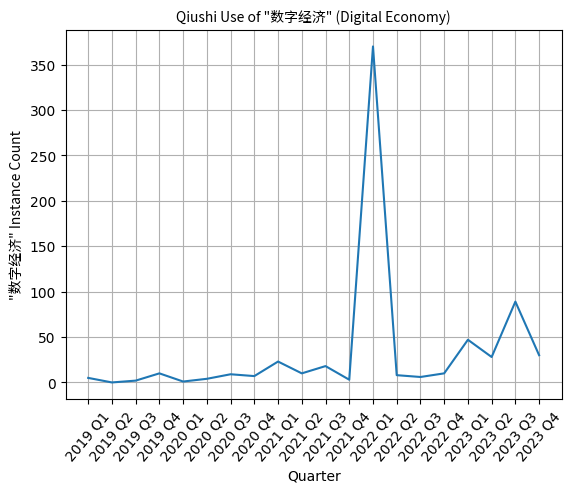

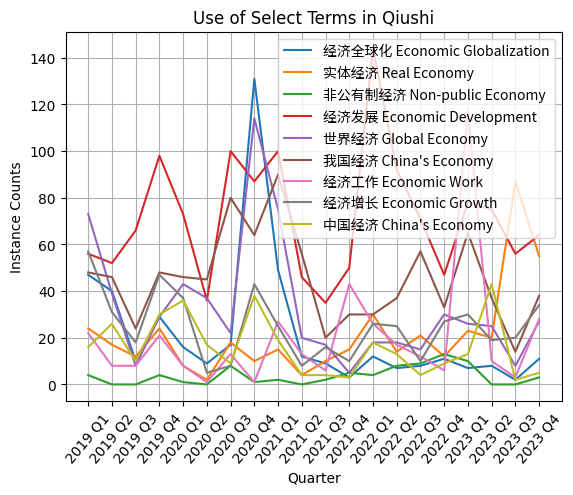

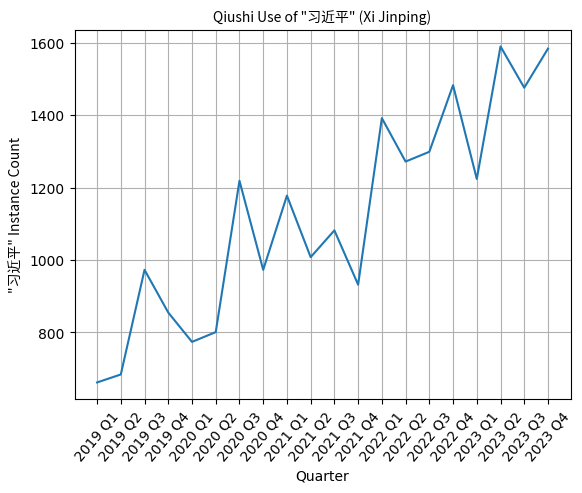

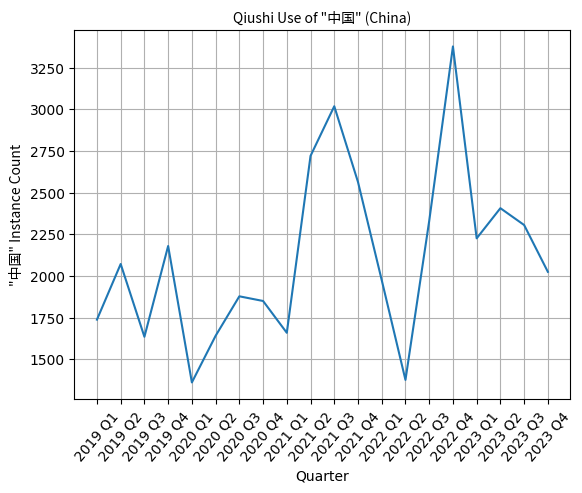

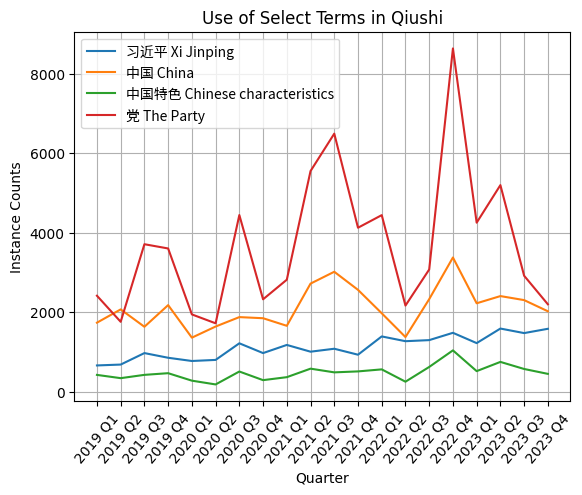

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from ipynb.fs.full.frequency_analysis import quarter_count

path = '/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/NotoSansSC-Regular.ttf'
font = font_manager.FontProperties(fname=path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = font.get_name()

def graph_top_n_ngrams(terms, title, y_lim=None, articles_df=None):
    if len(terms) > 5:
        fig, axs = plt.subplots(len(terms), sharex=True, sharey=True, figsize=(6, 10))

        clrs = sns.color_palette(n_colors=len(terms))

        for index, term in enumerate(terms):
            term_quarter_count = quarter_count(articles, term)
            xvals = list(term_quarter_count.keys())[:-1]
            yvals = list(term_quarter_count.values())[:-1]

            axs[index].plot(xvals, yvals, c=clrs[index])
            axs[index].legend([term])
            axs[index].set(xlabel='Quarter')
            axs[index].grid()
            axs[index].label_outer()
            axs[index].tick_params(axis='x', rotation=50)

            if y_lim:
                axs[index].set_ylim(y_lim)

        fig.suptitle(title)
        fig.supylabel("Instance Count")
        fig.tight_layout()
    else:
        fig, ax = plt.subplots()

        for term in terms:
            try:
                term_quarter_count = quarter_count(articles_df, term)
                xvals = list(term_quarter_count.keys())[:-1]
                yvals = list(term_quarter_count.values())[:-1]

                ax.plot(xvals, yvals, label=term)
            except:
                raise Exception("Error counting term in articles. Verify articles_df was provided")
            
        ax.set_xlabel("Quarter")
        ax.set_ylabel("Instance Counts")
        if y_lim:
            ax.set_ylim(y_lim)
        ax.set_title(title)
        ax.legend(prop=font)
        ax.tick_params(axis='x', rotation=50)
        ax.grid()

    # plt.savefig(f"../visuals/{save_string}frequency.png", bbox_inches='tight')
    plt.show()


In [5]:
terms = get_top_n_ngrams(articles, "经济", 1, 2)

{'2019 Q1': {'经济法律': 1, '把经济': 3, '经济立法': 1, '经济以': 1, '进入经济': 1, '经济成本': 1, '经济走廊': 3, '经济财富': 2, '贫困县经济': 1, '各种经济': 1, '日本经济': 3, '经济多样化': 1, '经济补偿': 1, '交往经济': 1, '万经济': 1, '经济蒙': 1, '国内经济': 1, '经济扩张': 1, '经济活': 1, '经济大海': 1, '作为经济': 2, '了经济': 10, '经济洼地': 1, '经济制度': 14, '中巴经济': 1, '经济仅能': 1, '经济管理': 1, '经济良性循环': 3, '罢了经济': 1, '个经济': 1, '经济困难': 1, '刑事经济': 1, '社会经济': 1, '经济活动': 5, '经济治理': 4, '欧元区经济': 7, '东盟国家经济': 1, '经济形势': 11, '管理经济': 1, '以经济': 5, '经济一度': 1, '充分运用经济': 1, '经济增速': 8, '经济待遇': 1, '经济总体': 2, '有关经济': 2, '封建经济': 1, '玉海经济': 1, '经济实现': 1, '对经济': 8, '俄经济': 2, '近年来经济': 1, '二经济': 1, '经济有望': 3, '镇域经济': 1, '经济手段': 1, '活经济': 1, '经济之中': 1, '显现经济': 1, '沿线经济': 1, '动力经济': 1, '对于经济': 2, '主题经济': 1, '唯有经济': 1, '经济长达': 1, '经济搞活': 1, '新增经济': 1, '当前经济': 1, '经济快速': 1, '意味着经济': 1, '涉及经济': 2, '经济欠发达': 1, '经济体量': 2, '经济丢': 1, '经济要': 1, '经济稳': 1, '经济合作': 6, '变化经济': 1, '经济方面': 3, '经济下行': 8, '平台经济': 2, '向经济': 1, '从经济': 4, '的经济': 19, '经济一体化': 1, '经济这种': 1, '经济展望': 1, '经济建设': 17, '经济剥削': 1, '首都经济': 

Exception: Error counting term in articles. Verify articles_df was provided

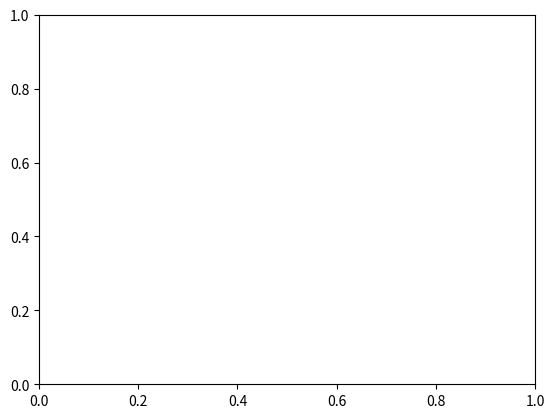

In [6]:
graph_top_n_ngrams(terms, "Most Common 经济 Bigrams", y_lim=[0, 150])

In [ ]:
terms = get_top_n_ngrams(articles, "经济", 2, 2)

{'2019 Q1': {'经济仍然': 1, '经济接近': 1, '经济立法': 1, '社会经济': 1, '应对经济': 1, '日本经济': 3, '多种经济': 1, '是经济': 9, '经济合作': 6, '经济走势': 1, '经济毫不动摇': 1, '北京经济': 1, '经济扩张': 1, '经济联动': 1, '经济活动': 5, '经济内生': 1, '经济政策': 5, '辉煌成就经济': 1, '对经济': 8, '促进经济': 8, '作为经济': 2, '在经济': 9, '区域经济': 3, '做好经济': 2, '意识形态经济': 3, '充分运用经济': 1, '经济积极参与': 1, '制定经济': 1, '南非经济': 1, '管理经济': 1, '调节经济': 1, '经济类': 1, '意味着经济': 1, '把经济': 3, '经济长期': 4, '经济决定论': 1, '无人经济': 1, '经济改革': 1, '全球经济': 12, '转变经济': 2, '局面经济': 1, '优化经济': 1, '各种经济': 1, '近年来经济': 1, '初见成效经济': 1, '万经济': 1, '经济深层次': 1, '必然结果经济': 1, '中央经济': 12, '推动经济': 18, '融入经济': 1, '经济发展前景': 1, '东盟国家经济': 1, '进行经济': 1, '经济结构': 10, '归咎于经济': 1, '经济持续': 8, '经济积极': 1, '俄经济': 2, '经济开放': 1, '向经济': 1, '经济实力': 1, '一切经济': 1, '经济发展壮大': 1, '经济高质量': 14, '货币贬值经济': 2, '经济从': 4, '经济这个': 1, '经济增长': 53, '经济大幅': 1, '经济双重': 1, '有关经济': 2, '年经济': 5, '刺激经济': 1, '经济制度': 14, '经济改善': 2, '公有制经济': 1, '经济复苏': 9, '经济一度': 1, '做大经济': 1, '经济篇': 1, '经济财富': 2, '各国经济': 2, '活经济': 1, '经济将': 1, '经济继续': 1, '数字经济': 5, '经济规模':

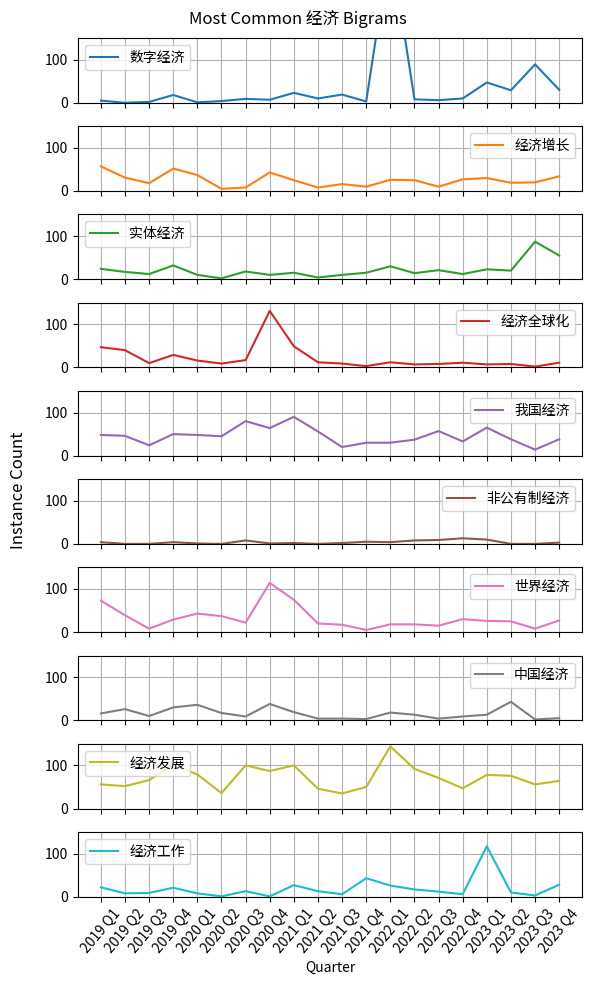

In [146]:
graph_top_n_ngrams(terms, "Most Common 经济 Bigrams", y_lim=[0, 150])

In [7]:
terms = get_top_n_ngrams(articles, "经济", 1, 3)
terms

{'2019 Q1': {'世界经济大幅': 1, '经济增长并': 1, '战略积极参与经济': 1, '结构变化经济': 1, '符合我国经济': 1, '之上表明经济': 1, '经济建设上来': 1, '时期谋划经济': 1, '逆风世界经济': 1, '经济全球化繁荣': 1, '经济结构是': 1, '经济继续发展': 1, '经济正加速': 1, '世界经济仍': 3, '为世界经济': 4, '的世界经济': 2, '欧元区经济增长': 1, '—通过经济': 1, '我国经济结构': 2, '着经济健康': 1, '年均经济增长率': 1, '主要经济手段': 1, '万经济的': 1, '经济增速将': 2, '表明经济仍': 1, '经济工作的': 6, '发生变化一是经济': 1, '稳经济稳': 1, '经济建设扩大': 1, '阐明了经济': 1, '经济跨越式发展': 1, '经济的着力点': 1, '中经济建设': 1, '各种经济成分': 1, '实体经济企业': 1, '我国经济规模': 1, '根本动力经济': 1, '里为经济': 1, '经济建设和': 1, '但经济全球化': 1, '经济搞活改革': 1, '经济是中轴线': 1, '经济稳中有变': 1, '经营企业法个人所得税法经济': 1, '经济全球化程度': 1, '进入经济全球化': 1, '管理经济和': 1, '将为经济': 1, '经济建设任务': 1, '发布世界经济': 1, '对内经济搞活': 1, '和经济发展': 2, '多种所有制经济': 2, '经济结构继续': 1, '发展经济无疑': 1, '是推动经济': 1, '实体经济之中': 1, '看待当前经济': 1, '把发展经济': 2, '绿色经济发展': 1, '日益频繁经济合作': 1, '经济的主体': 1, '将世界经济': 1, '历史时期经济': 1, '复杂严峻经济': 1, '经济结构和': 1, '一厢情愿罢了经济': 1, '是世界经济': 4, '经济走廊历史': 1, '区域经济合作': 1, '走出经济洼地': 1, '经济剥削人民': 1, '指明了经济': 1, '方向中央经济': 1, '对中国经济': 1, '经济增长带来': 1, '年俄经济': 1

['世界经济增长',
 '我国经济发展',
 '现代化经济体系',
 '基本经济制度',
 '县域经济发展',
 '数字经济发展',
 '经济高质量发展',
 '中国经济发展',
 '中央经济工作',
 '经济全球化的',
 '社会主义基本经济',
 '经济和实体']

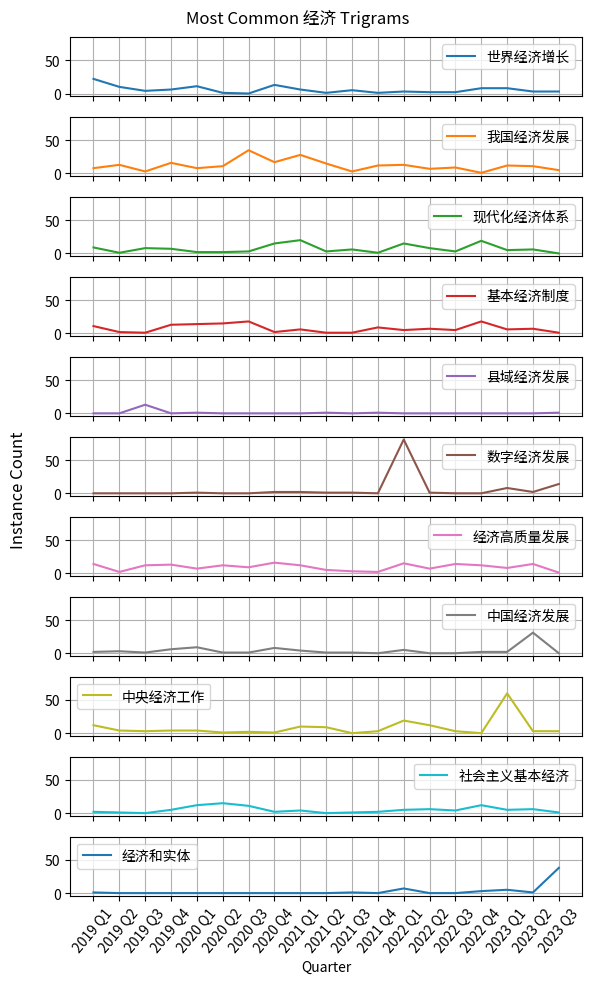

In [8]:
terms.remove('经济全球化的')
graph_top_n_ngrams(terms, "Most Common 经济 Trigrams")

In [9]:
terms = get_top_n_ngrams(articles, "国际", 1, 3)
terms

{'2019 Q1': {'国际环境看新': 1, '全新路径国际': 1, '经济全球化国际': 1, '形成适应国际': 1, '国际地位没有': 1, '照搬国际金融危机': 1, '承接国际产业': 1, '国际社会坚持': 2, '国际传播领域': 2, '国际濒危物种': 1, '国际视野把握': 2, '国际社会的': 4, '从国际看': 1, '优秀成果加强国际': 1, '它是国际': 1, '企业提升国际': 1, '和国际竞争力': 2, '年国际油价': 2, '日本海国际空域': 1, '对国际国内形势': 1, '国际新秩序': 1, '应对气候变化国际': 1, '五是把握国际': 1, '国际关系问题': 1, '国际国内存在': 1, '是从国际环境': 1, '国际规则制定': 2, '国际秩序支持': 1, '国际环境发生': 1, '城国际商贸城': 1, '一带一路国际': 3, '国际秩序的': 1, '当时国际国内': 1, '体制加快国际': 1, '深入发展国际': 1, '国际传播能力': 1, '国际政治经济格局': 1, '已得到国际': 1, '出口订单国际': 1, '性能指标达到国际': 1, '姿态赢得国际': 1, '不足国际传播': 1, '产业国际分工协作': 1, '达到国际领先水平': 1, '国际先进水平': 1, '国际看发展': 1, '取向的国际': 1, '反腐败国际追逃': 2, '东升西降国际': 1, '的贡献者国际': 1, '大国际社会': 1, '国际股市汇市': 1, '国际社会普遍认为': 3, '打造国际合作': 2, '国际比武他敢': 1, '新型国际关系': 7, '国际上首次': 1, '的国际环境': 1, '复杂多变的国际': 1, '和国际比武': 1, '要把握国际': 1, '是国际上': 1, '的国际市场': 1, '积极参与国际规则': 1, '同国际社会': 1, '平衡国际油价': 1, '国际科技竞争': 1, '国际收支平衡改善': 1, '国际关系准则': 1, '由于国际国内形势': 1, '国际上首个': 1, '国际影响力的': 1, '环境署等国际': 1, '的国际环境变': 1, '国际著名学术刊物': 1, '向日内

['疫情防控国际',
 '国内国际双循环',
 '国际科技竞争',
 '履行国际义务',
 '国际进口博览会',
 '站在国际',
 '一带一路国际',
 '国际传播能力',
 '新型国际关系',
 '大兴国际机场',
 '国际两个大局']

In [10]:
terms = get_top_n_ngrams(articles, "中国", 3, 2)
terms

{'2019 Q1': {'首个中国': 1, '中国丝路': 1, '亿多中国': 1, '中国大约': 1, '中国梦共担': 1, '具有中国': 5, '中国人要': 1, '二中国': 1, '中国互联网络': 1, '中国梦为': 2, '中国农民': 2, '中国和平': 12, '中国取得': 1, '中国实际': 6, '中国巨轮': 1, '下调中国': 1, '提出中国': 1, '强加在中国': 1, '中国将': 8, '首飞中国': 1, '比较中国': 1, '震惊中国': 1, '动力中国': 1, '说中国': 4, '生命力中国': 1, '攸关中国': 1, '被誉为中国': 1, '中国过去': 2, '推进中国': 6, '宣示中国': 1, '中国4K': 1, '中国这篇大': 1, '风潮中国': 1, '作为中国': 3, '飞跃中国': 6, '全体中国': 2, '中国生产力': 1, '中国品牌': 2, '给中国': 2, '在实践上中国': 1, '中国不能': 1, '中国边疆': 1, '摄中国': 3, '中国搞': 3, '老路中国': 1, '而言中国': 1, '提升中国': 1, '建设中国': 9, '全党中国': 1, '中国第二': 1, '看到中国': 2, '古代中国': 4, '中国对': 9, '作用中国': 1, '—中国': 5, '日中国': 3, '坚定中国': 2, '明确中国': 1, '综合国力中国': 1, '中国国内': 2, '中国艰苦卓绝': 1, '中国环保': 1, '中国最': 3, '欢迎中国': 1, '牢记中国': 1, '中国写照': 1, '梦想中国': 1, '打中国': 1, '特点中国': 1, '中国充满信心': 1, '确认中国': 1, '看待中国': 1, '结果中国': 1, '年来中国': 3, '中国精神': 4, '中国马克思主义': 3, '中国社会': 8, '探索中国': 2, '中国变成': 1, '进行中国': 1, '获中国': 1, '中国航空': 1, '领袖中国': 1, '中国今后': 1, '中国有望': 1, '中国已': 4, '延伸中国': 1, '亦可覆舟中国': 1, '世界中国': 1,

['中国人权', '时代中国', '中国特色', '当代中国', '新中国', '中国人民', '中国革命']

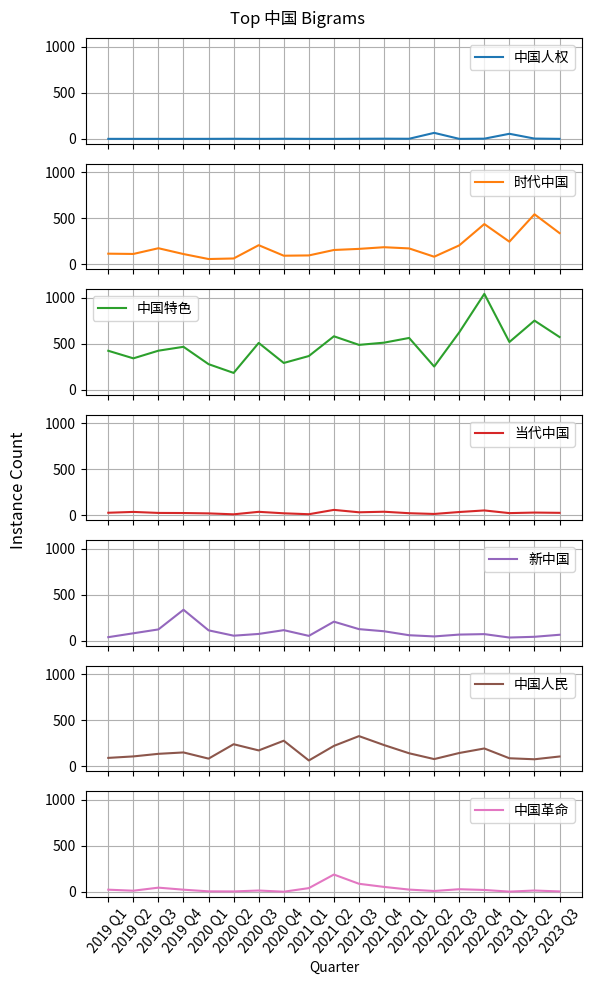

In [11]:
graph_top_n_ngrams(terms, "Top 中国 Bigrams", articles_df=articles)

In [12]:
terms = get_top_n_ngrams(articles, "疫情", 2, 2)
terms

{'2019 Q1': {}, '2019 Q2': {'疫情此伏': 1, '饥荒疫情': 1}, '2019 Q3': {'疫情给': 1, '非典疫情': 2, '疫情2008': 1}, '2019 Q4': {'防控疫情': 1, '猪瘟疫情': 1, '疫情此伏': 1, '疫情防控': 1, '饥荒疫情': 1, '疫情恢复': 1}, '2020 Q1': {'经济布局疫情': 1, '保持疫情': 1, '一道道疫情': 1, '运筹帷幄疫情': 1, '古代疫情': 1, '三农疫情': 1, 'SARS疫情': 3, '危害疫情': 4, '心理健康疫情': 1, '谈疫情': 1, '疫情提供': 4, '保障疫情': 11, '疫情中国政府': 1, '传染病疫情': 3, '守好疫情': 1, '疫情传染性': 1, '全村疫情': 1, '适应疫情': 1, '成为疫情': 3, '万计疫情': 1, '利用疫情': 5, '同时疫情': 1, '解决疫情': 3, '反复强调疫情': 1, '值得疫情': 1, '疫情树立': 1, '疫情迅速': 3, '周围疫情': 1, '疫情加快': 7, '疫情充满信心': 1, '财政疫情': 1, '疫情犯罪案件': 1, '疫情稳定': 1, '疫情5': 1, '加速疫情': 1, '等疫情': 13, '融入疫情': 1, '履职疫情': 1, '通报疫情': 6, '疫情袭来': 2, '疫情心理': 1, '疫情增添': 1, '懈怠疫情': 2, '方面疫情': 1, '大放异彩疫情': 1, '疫情就是': 12, '非典疫情': 3, '自疫情': 1, '国际疫情': 1, '企业疫情': 1, '疫情作为': 1, '调度疫情': 1, '疫情党和政府': 1, '疫情人民战争': 1, '疫情趋势': 1, '重于泰山疫情': 4, '疫情一天': 2, '疫情分区': 1, '漏洞疫情': 1, '开展疫情': 21, '疫情迁延': 2, '疫情和': 4, '疫情期间': 16, '疫情战役': 2, '止争疫情': 1, '疫情84': 1, '疫情专栏': 1, '防控疫情': 38, '看到疫情': 3, '疫情直接': 1, '有关疫情': 2, '传

['新冠疫情', '防控疫情', '非典疫情', '肺炎疫情', '猪瘟疫情', '疫情此伏', '疫情防控', '疫情给', '饥荒疫情']

In [13]:
terms = get_top_n_ngrams(articles, "人权", 1, 3)
terms

{'2019 Q1': {'举行联合国人权': 1, '在人权领域': 1, '人权史上具有': 1, '世界人权史上': 1, '发展和人权': 1, '人权理事会第': 1, '联合国人权理事会': 1, '人权领域促进': 1, '和人权进步': 1, '人权进步划时代': 1, '和世界人权': 1, '的在人权': 1}, '2019 Q2': {'治理研究院人权': 1, '研究院人权研究': 1, '人权研究中心': 1, '知识产权人权法治': 1, '联合国教科文组织和人权': 1, '和人权理事会': 1, '人权理事会等': 1, '金融体系知识产权人权': 1, '人权法治和': 1}, '2019 Q3': {'完善人权司法': 1, '人权免遭恐怖主义': 1, '的基本人权': 1, '人权司法保障制度': 1, '司法制度完善人权': 1, '基本人权免遭': 1}, '2019 Q4': {'民主自由人权的': 1, '标榜民主自由人权': 1, '人权的帝国主义': 1}, '2020 Q1': {'基本人权不能': 1, '人权司法保障': 1, '人权不能突破': 1, '行为强化人权': 1, '人权等问题': 1, '强化人权司法': 1, '人权的原则': 1, '涉藏人权等': 1, '涉疆涉藏人权': 1, '保障基本人权': 2, '基本人权的': 1}, '2020 Q2': {'人权事业发展': 4, '中人权保障': 1, '基本人权在': 1, '基本人权主要': 1, '一种消极人权': 1, '普遍性人权保障': 1, '人权强调国家': 1, '人权价值观决定': 1, '是人权保护': 2, '和保护人权': 1, '人权法律准则': 1, '发展促进人权': 1, '社会主义人权理论': 2, '人权的基座': 1, '把人权考虑': 1, '处于人权的': 1, '人权保护的': 2, '基本人权具有': 1, '人权的普遍性': 1, '人权的衔接': 1, '了普遍性人权': 1, '必须把人权': 1, '人权价值理念': 1, '人权全面深度': 1, '保护是人权': 1, '人权生命是': 1, '作为重点人权': 1, '联合国人权公约': 1, '人权事业的': 1, '人权等同

['人权事业发展',
 '治理研究院人权',
 '涉疫人权等',
 '举行联合国人权',
 '我国人权保障',
 '人权看美政客',
 '治理推动人权',
 '西藏人权事业',
 '全球人权治理',
 '联合国人权理事会',
 '完善人权司法',
 '民主自由人权的',
 '标榜人权至上',
 '时代中国人权',
 '保障基本人权']

#### Ngl, this was... not has helpful/useful as I hoped. We need a way to dynamically parse which phrases are the most common, and it would be great if we could compare between them in a way that actually worked... like if we could do 数字经济 and 经济高质量发展